# PySDDR: An Advanced Tutorial

In the beginner's guide only tabular data was used as input to the PySDDR framework. In this advanced tutorial we show the effects when combining structured and unstructured data. Currently, the framework only supports images as unstructured data.

We will use the MNIST dataset as a source for the unstructured data and generate additional tabular features corresponding to those. Our outcome in this tutorial is simulated based on linear and non-linear effects of tabular data and a linear effect of the number shown on the MNIST image. Our model is not provided with the (true) number, but instead has to learn the number effect from the image (together with the structured data effects):
\begin{equation*}
y = \sin(x_1) - 3x_2 + x_3^4 + 3\cdot number + \epsilon
\end{equation*}
with $\epsilon \sim \mathcal{N}(0, \sigma^2)$ and $number$ is the number on the MNIST image.

The aim of training is for the model to be able to output a latent effect, representing the number depicted in the MNIST image.

We start by importing the sddr module and other required libraries

In [ ]:
!pip install ..

Processing /hkfs/home/haicore/scc/pa6512/PySSDR
  Preparing metadata (setup.py) ... done
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinu

In [2]:
# import the sddr module
from sddr import Sddr

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#set seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)

ModuleNotFoundError: No module named 'sddr'

### User inputs 

First the user defines the data to be used. The data is loaded and if it does not already exist, a column needs to be added to the tabular data describing the unstructured data - structured data correspondence. In the example below we add a column where each item includes the name of the image to which the current row of tabular data corresponds.

In [2]:
data_path = '../data/mnist_data/tab.csv'

data = pd.read_csv(data_path,delimiter=',')

# append a column for the numbers: each data point contains a file name of the corresponding image
for i in data.index:
    data.loc[i,'numbers'] = f'img_{i}.jpg'

In [38]:
data

,x1,x2,x3,y_gen,y_true,numbers
0,2.606303,-0.141809,0.053795,-11.283425,2,img_0.jpg
1,2.746226,-0.813898,0.753431,12.308747,9,img_1.jpg
2,-1.343725,-0.325541,0.249850,-8.534480,3,img_2.jpg
3,2.076264,0.378157,-0.444105,-5.306146,4,img_3.jpg
4,0.890613,-1.994485,-0.050270,-10.098662,0,img_4.jpg
...,...,...,...,...,...,...
7995,-2.771807,0.670894,0.611563,-0.159374,7,img_7995.jpg
7996,1.900410,-0.998891,0.207087,9.028810,7,img_7996.jpg
7997,-0.305296,0.377886,0.535751,0.410818,7,img_7997.jpg
7998,-0.995108,-0.223575,1.437215,-6.987264,3,img_7998.jpg


In [37]:
data.shape

(8000, 6)

Next the distribution, formulas and training parameters are defined. The size of each image is ```28x28``` so our neural network has a layer which flattens the input, which is followed by a linear layer of input size ```28x28``` and an output size of ```128```. Finally, this is followed by a ```ReLU``` for the activation.

Here the structured data is not pre-loaded as it would be typically too large to load in one step. Therefore the path to the directory in which it is stored is provided along with the data type (for now only 'images' supported). The images are then loaded in batches using PyTorch's dataloader. Note that here again the key given in the ```unstructured_data``` dictionary must match the name it is given in the formula, in this case ```'numbers'```. Similarly the keys of the ```deep_models_dict``` must also match the names in the formula, in this case ```'dnn'```

In [3]:
# define distribution and the formula for the distibutional parameter
distribution  = 'Normal'

formulas = {'loc': '~ -1 + spline(x1, bs="bs", df=10) + x2 + dnn(numbers) + spline(x3, bs="bs", df=10)',
            'scale': '~1'
            }


# define the deep neural networks' architectures and output shapes used in the above formula
deep_models_dict = {
'dnn': {
    'model': nn.Sequential(nn.Flatten(1, -1),
                           nn.Linear(28*28,128),
                           nn.ReLU()),
    'output_shape': 128},
}

# define your training hyperparameters
train_parameters = {
    'batch_size': 8000,
    'epochs': 1000,
    'degrees_of_freedom': {'loc':9.6, 'scale':9.6},
    'optimizer' : optim.Adam,
    'val_split': 0.15,
    'early_stop_epsilon': 0.001,
    'dropout_rate': 0.01
}


# provide the location and datatype of the unstructured data
unstructured_data = {
  'numbers' : {
    'path' : '../data/mnist_data/mnist_images',
    'datatype' : 'image'
  }
}

# define output directory
output_dir = './outputs'


### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step:

In [4]:
sddr = Sddr(output_dir=output_dir,
            distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            )

Using device:  cpu


In [5]:
sddr

### Training

The sddr network is trained with the data defined above and the loss curve is plotted.

In [14]:
sddr.train(structured_data=data,
           target="y_gen",
           unstructured_data = unstructured_data,
           plot=True)

Beginning training ...
Train Epoch: 0 	 Training Loss: 129.025711
Train Epoch: 0 	 Validation Loss: 143.753311


KeyboardInterrupt: 

In [20]:
sddr.dataset.get_list_of_feature_names()

['x1', 'x2', 'x3', 'y_true', 'numbers']

In [29]:
sddr.dataset.prepared_data.keys()

dict_keys(['loc', 'scale'])

In [32]:
print(sddr.dataset.prepared_data['loc'].keys())

dict_keys(['structured', 'dnn'])


In [35]:
sddr.dataset.prepared_data['loc']['structured'].shape # M

torch.Size([8000, 21])

In [39]:
sddr.dataset.prepared_data['loc']['structured']

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4356e-01, 1.2702e-03,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.6371e-01,  ..., 2.0761e-04, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6128e-02, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.8173e-02,  ..., 4.8297e-01, 1.1941e-01,
         3.0102e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.5218e-01, 8.0059e-02,
         8.5850e-04]])

In [40]:
sddr.dataset.prepared_data['scale']['structured'].shape

torch.Size([8000, 1])

In [ ]:
sddr.dataset.prepared_data['loc']['structured']

### Evaluation - Visualizing the partial effects

In this case the data is assumed to follow a normal distribution, in which case two distributional parameters, loc and scale, need to be estimated. Below we plot the partial effects of each smooth term.

Remember the partial effects are computed by: partial effect = smooth_features * coefs (weights)
In other words the smoothing terms are multiplied with the weights of the Structured Head. We use the partial effects to interpret whether our model has learned correctly.

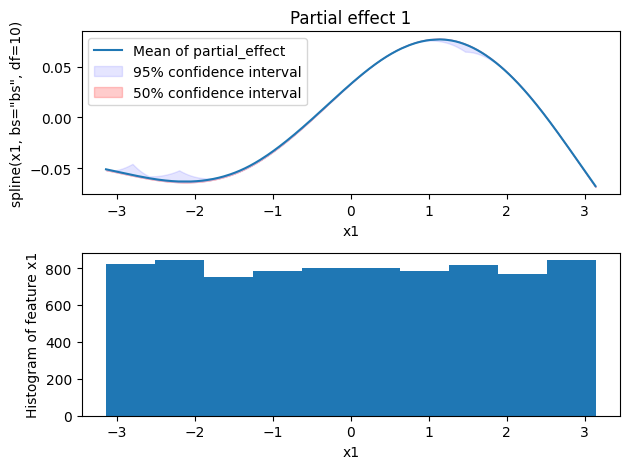

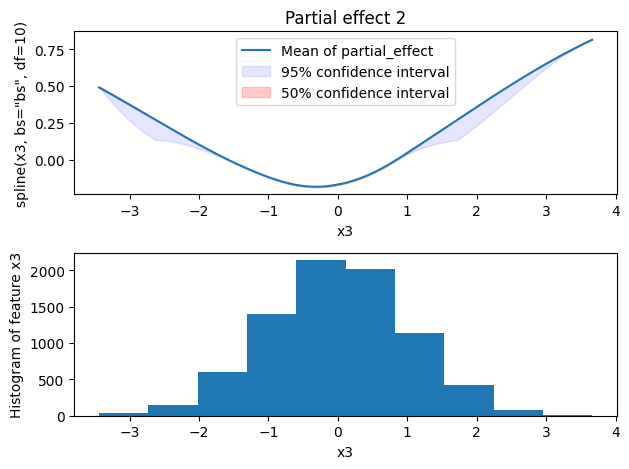

In [6]:
partial_effects_loc = sddr.eval('loc',plot=True)

In [7]:
partial_effects_scale = sddr.eval('scale',plot=True)

Nothing to plot. No (non-)linear partial effects specified for this parameter. (Deep partial effects are not plotted.)


As we can see the distributional parameter loc has two parial effects, one sinusoidal and one quadratic. The parameter scale expectedly has no partial effect since the formula only includes an intercept.

Next we retrieve our ground truth data and compare it with the model's estimation

Predicted variance for first sample: tensor([1.3774])


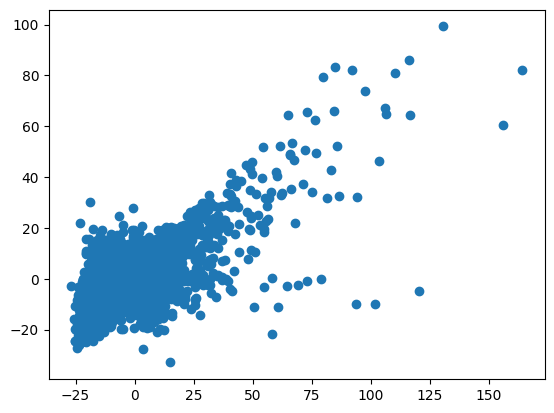

In [8]:
# compare prediction of neural network with ground truth
data_pred = data.loc[:,:]
ground_truth  = data.loc[:,'y_gen']

# predict returns partial effects and a distributional layer that gives statistical information about the prediction
distribution_layer, partial_effect = sddr.predict(data_pred,
                                                  clipping=True, 
                                                  plot=False, 
                                                  unstructured_data = unstructured_data)
# retrieve the mean and  variance of the distributional layer
predicted_mean = distribution_layer.loc[:,:].T
predicted_variance = distribution_layer.scale[0]

# and plot the result
plt.scatter(ground_truth, predicted_mean)
print(f"Predicted variance for first sample: {predicted_variance}")

The comparison shows that for most samples the predicted and true values are directly propotional.

Next we want to check if the model learned the correct correspondence of images and numbers

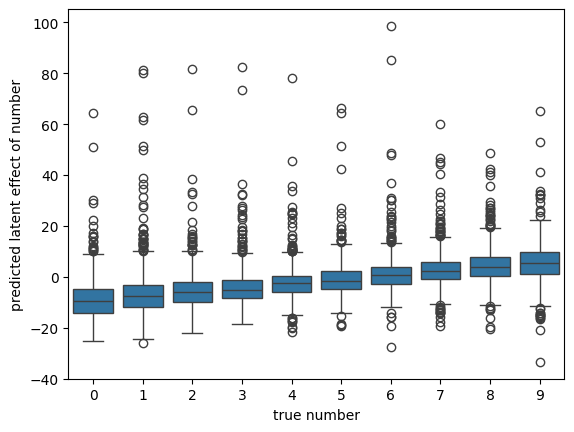

In [9]:
# we create a copy of our original structured data where we set all inputs but the images to be zero
data_pred_copy = data.copy()
data_pred_copy.loc[:,'x1'] = 0
data_pred_copy.loc[:,'x2'] = 0
data_pred_copy.loc[:,'x3'] = 0

# and make a prediction using only the images
distribution_layer, partial_effect = sddr.predict(data_pred_copy,
                                                  clipping=True, 
                                                  plot=False, 
                                                  unstructured_data = unstructured_data)
# add the predicted mean value to our tabular data
data_pred_copy['predicted_number'] = distribution_layer.loc[:,:].numpy().flatten()

# and compare the true number on the images with the predicted number
ax = sns.boxplot(x="y_true", y="predicted_number", data=data_pred_copy)

ax.set_xlabel("true number");
ax.set_ylabel("predicted latent effect of number");

Observing the boxplot figure we see that as the true values, i.e. numbers depicted on images, are increasing, so too are the medians of the predicted distributions. Therefore the partial effect of the neural network is directly correlated with the number depicted in the MNIST images, proving that our neural network, though simple, has learned from the unstructured data.